# Lanczos Interpolation (Interpolating with Discrete Convolutions)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
import skimage as ski

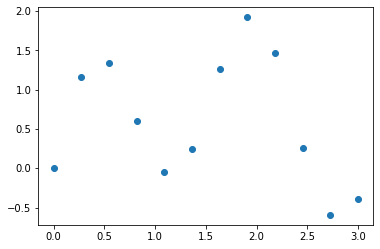

In [125]:
x = np.linspace(0.0, 3.0, 12)
#x = np.arange(-3.0, 3.0, 0.5)
#y = 0.6 * x**4 + 0.3 * x**3 - 5.5 * x**2 + 1.75 * x + 10.0
#y = np.ones_like(y)
y = np.sin(4.0 * x) + np.sin(x)
plt.scatter(x, y);

In [126]:
xp = np.zeros(2 * x.shape[0])
xp[::2] = x
xp[1::2] = x + np.diff(x)[0] / 2
x, xp

(array([0.    , 0.2727, 0.5455, 0.8182, 1.0909, 1.3636, 1.6364, 1.9091,
        2.1818, 2.4545, 2.7273, 3.    ]),
 array([0.    , 0.1364, 0.2727, 0.4091, 0.5455, 0.6818, 0.8182, 0.9545,
        1.0909, 1.2273, 1.3636, 1.5   , 1.6364, 1.7727, 1.9091, 2.0455,
        2.1818, 2.3182, 2.4545, 2.5909, 2.7273, 2.8636, 3.    , 3.1364]))

In [127]:
yp = np.zeros(2 * y.shape[0])
yp[::2] = y
y, yp

(array([ 0.    ,  1.1564,  1.3379,  0.5991, -0.0528,  0.2416,  1.2571,
         1.9197,  1.4614,  0.2509, -0.5937, -0.3955]),
 array([ 0.    ,  0.    ,  1.1564,  0.    ,  1.3379,  0.    ,  0.5991,
         0.    , -0.0528,  0.    ,  0.2416,  0.    ,  1.2571,  0.    ,
         1.9197,  0.    ,  1.4614,  0.    ,  0.2509,  0.    , -0.5937,
         0.    , -0.3955,  0.    ]))

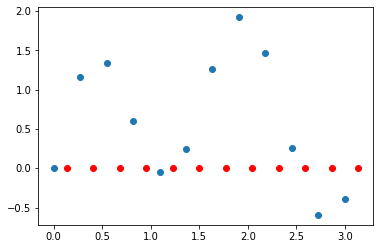

In [128]:
plt.scatter(xp[::2], yp[::2]);
plt.scatter(xp[1::2], yp[1::2], color='red', marker='o');

In [139]:
factor = 5
order = 23
radius = order // factor

taps = np.linspace(-radius, radius, 2 * order - 1)
sinc = np.sinc(taps)
lobe = np.sinc(taps / radius)

lanczos = sinc * lobe

len(lanczos)

45

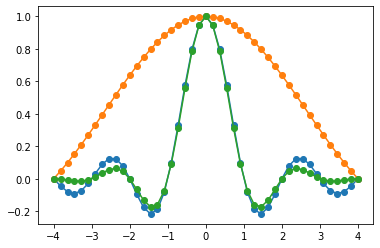

In [140]:
plt.plot(taps, sinc, marker='o');
plt.plot(taps, lobe, marker='o');
plt.plot(taps, lanczos, marker='o');

In [141]:
def lanczos_filter(factor, order):
    radius = order // factor
    taps = np.linspace(-radius, radius, 2 * order - 1)
    return np.sinc(taps) * np.sinc(taps / radius)

In [142]:
filt = lanczos_filter(2, 9)
len(filt)

17

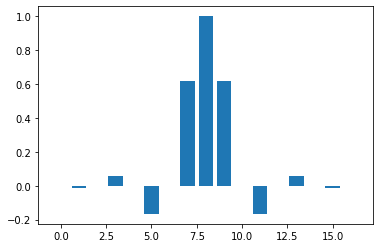

In [143]:
plt.bar(range(len(filt)), filt);

In [144]:
filt[len(filt) // 2]

1.0

In [145]:
y_interp = np.convolve(yp, filt, mode='same')
x.shape, xp.shape, yp.shape, y_interp.shape, filt.shape

((12,), (24,), (24,), (24,), (17,))

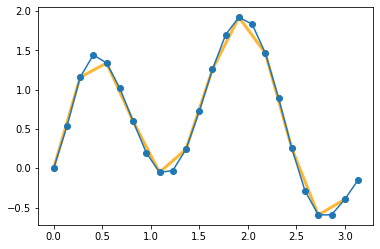

In [146]:
plt.plot(x, y, linewidth=3, color='orange', alpha=0.8, marker='o');
plt.plot(xp, y_interp, marker='o');

In [221]:
t = np.linspace(0.0, 5.0 * np.pi, 20)
#s = sp.signal.sawtooth(t)
s = sp.signal.square(t)
s.shape

(20,)

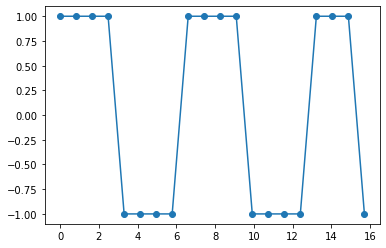

In [222]:
plt.plot(t, s, marker='o');

In [223]:
def upsample1d(y, factor, order):
    yp = np.zeros(factor * y.shape[0])
    yp[::factor] = y
    
    filt = lanczos_filter(factor, order)
    return np.convolve(yp, filt, mode='same')

In [224]:
factor = 5
order = 9

su = upsample1d(s, factor, order)

In [225]:
tu = np.zeros(factor * t.shape[0])
tu[::factor] = t

for i in range(1, factor):
    tu[i::factor] = t + np.diff(t)[0] / factor
su.shape, tu.shape

((100,), (100,))

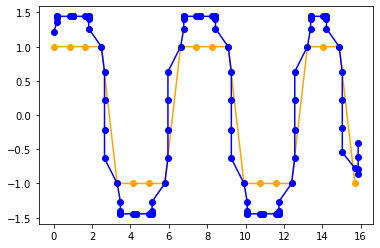

In [226]:
plt.plot(t, s, marker='o', color='orange');
plt.plot(tu, su, marker='o', color='blue');

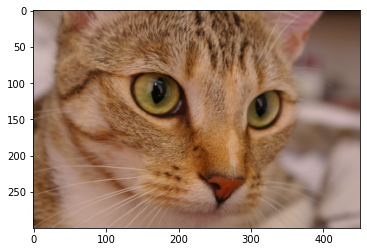

In [20]:
img = ski.img_as_float(ski.data.chelsea());
plt.imshow(img);

In [21]:
img.shape

(300, 451, 3)

((60, 90, 3), 0.023877892208854976, 0.8095279369870125)

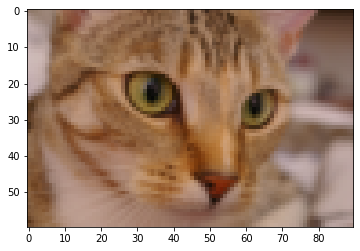

In [35]:
imgd = ski.transform.rescale(img, 0.2, multichannel=True)
#imgd = np.ones_like(imgd)
plt.imshow(imgd);
imgd.shape, imgd.min(), imgd.max()

In [36]:
factor = 5
order = 13

In [37]:
imgp = np.zeros((factor * imgd.shape[0], factor * imgd.shape[1], imgd.shape[2]))
imgp[::factor, ::factor, :] = imgd

imgd.shape, imgp.shape

((60, 90, 3), (300, 450, 3))

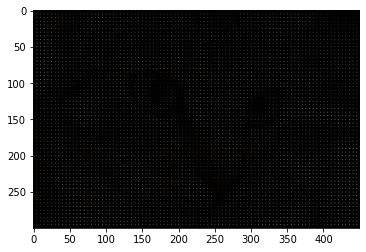

In [38]:
plt.imshow(imgp);

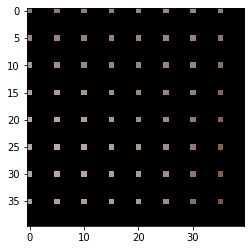

In [39]:
plt.imshow(imgp[:40, :40]);

In [40]:
def lanczos_filt_radial(factor, order):
    radius = order // factor
    
    taps = np.linspace(-radius, radius, 2 * order - 1)
    xtaps, ytaps = np.meshgrid(taps, taps, copy=False)
    dist = np.sqrt(xtaps**2 + ytaps**2)

    filt = np.sinc(dist) * np.sinc(dist / radius)
    filt[dist > radius] = 0.0
    return filt

In [41]:
filt2d = lanczos_filt_radial(factor, order)
filt2d.shape, filt2d.min(), filt2d.max(), filt2d[0, -1], filt2d[2, 0]

((25, 25), -0.08642303956077911, 1.0, 0.0, 0.0)

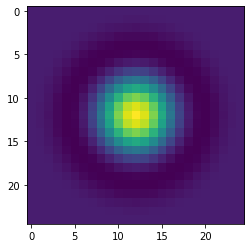

In [42]:
plt.imshow(filt2d);

In [60]:
imgu = np.stack([sp.signal.convolve2d(imgp[:, :, chan], filt2d, mode='same', boundary='fill') for chan in range(3)], axis=-1)
imgu.shape

(300, 450, 3)

In [61]:
imgu.min(), imgu.max()

(-0.03749188349204836, 1.03862934042579)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


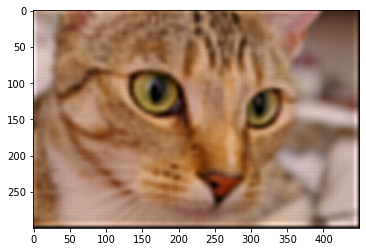

In [62]:
#plt.imshow(imgu * (imgd.max() / imgu.max()));
plt.imshow(imgu);

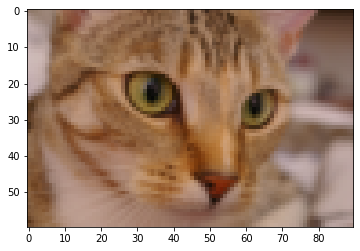

In [63]:
plt.imshow(imgd);

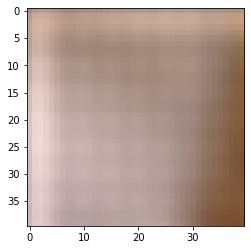

In [46]:
plt.imshow(imgu[:40, :40]);

0.7830058207564814